In [2]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import dataprep
from dataprep.eda import create_report
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, pearsonr
import matplotlib.pyplot as plt


In [3]:
path = '/Users/Marcy_Student/Desktop/CID_data-slayer-corps/data/etl/sql/CID_database_clean.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

# Get all table names
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
print("Available tables in database:")
print(tables)
print(f"\nTotal tables: {len(tables)}")

table = ['dim_environment', 'dim_location', 'dim_demographic','fact_school_outcomes']

results = {}
for t in table:
    query = f'SELECT * FROM {t}'
    results[t] = pd.read_sql_query(query, conn)

dim_environment = results['dim_environment']
dim_location = results['dim_location']
dim_demographic = results['dim_demographic']
fact_school_outcomes = results['fact_school_outcomes']

Available tables in database:
                   name
0       dim_environment
1          dim_location
2       dim_demographic
3  fact_school_outcomes
4       sqlite_sequence

Total tables: 5


# Full Beta Regression Pipeline: Predicting CCR

**Target:** 4-Year College & Career Readiness (CCR) — a bounded proportion (0–100%), modeled via Beta Regression with a logit link.

**Features:**
| Feature | Source | Type |
|---|---|---|
| `economic_need_index` | dim_environment | Structural |
| `log_temp_housing` | dim_environment (log-transformed) | Structural |
| `teaching_environment_pct_positive` | dim_environment | Modifiable |
| `eni_x_teach` | Interaction: ENI × Teaching Env | Interaction |
| `avg_student_attendance` | dim_environment | Modifiable |
| `student_support_pct` | env_dim.csv (not in DB) | Modifiable |
| `borough_*` | dim_location (one-hot encoded) | Geographic |

**Pipeline steps:**
1. Data preparation & feature engineering
2. 80/20 train/test split
3. Standard scaling (numerical features only, fit on train)
4. Beta regression fit with logit link
5. Predictions & back-transformation
6. Evaluation metrics
7. Diagnostic visualizations
8. Coefficient interpretation & summary

## Step 1: Data Preparation & Feature Engineering

- Merge `dim_environment` + `dim_location` 
- Engineer features: log(temp housing), ENI × teaching interaction, borough one-hot encoding
- Apply **Smithson-Verkuilen transformation** to squeeze CCR into the open interval (0, 1) as required by beta regression

In [4]:
import warnings
warnings.filterwarnings('ignore')


# Load Student Support from the raw CSV (not in the database)
csv_path = '/Users/Marcy_Student/Desktop/CID_data-slayer-corps/data/csv/env_dim.csv'
env_csv = pd.read_csv(csv_path)

env_csv = env_csv[['DBN', 'Student Support - School Percent Positive']].copy()
env_csv.rename(columns={'Student Support - School Percent Positive': 'student_support_pct'}, inplace=True)

env_csv['student_support_pct'] = (
    env_csv['student_support_pct']
    .astype(str)
    .str.replace('%', '', regex=False)
    .apply(pd.to_numeric, errors='coerce')
    / 100.0
)

print(f'Student Support loaded from CSV: {env_csv["student_support_pct"].notna().sum()} non-null values')
print(f'  Range: {env_csv["student_support_pct"].min():.2f} – {env_csv["student_support_pct"].max():.2f}')

# Merge environment + location (borough) + student support (from CSV)
model_df = (
    dim_environment
    .merge(dim_location[['DBN', 'borough','district']], on='DBN', how='inner')
    .merge(env_csv, on='DBN', how='left')
)
cols_needed = ['district','economic_need_index', 'percent_temp_housing',
               'teaching_environment_pct_positive',
               'avg_student_attendance', 'student_support_pct',
               'metric_value_4yr_ccr_all_students', 'borough']
numerical_cols = ['economic_need_index', 'percent_temp_housing',
               'teaching_environment_pct_positive',
               'avg_student_attendance', 'student_support_pct',
               'metric_value_4yr_ccr_all_students']


# compute missing values using the average metric per district
for col in numerical_cols:
    model_df[col] = model_df[col].fillna(model_df.groupby('district')[col].transform('mean'))

# one district do not have its ccr reported at all dist 84, we will drop it
model_df = model_df[cols_needed].dropna().copy()

print(f'\nTotal schools after dropping NaN: {len(model_df)}')
print(f'Borough distribution:\n{model_df["borough"].value_counts().to_string()}\n')

# Feature Engineering
model_df['log_temp_housing'] = np.log(model_df['percent_temp_housing'] + 0.001)
model_df['eni_x_teach'] = model_df['economic_need_index'] * model_df['teaching_environment_pct_positive']

borough_dummies = pd.get_dummies(model_df['borough'], prefix='borough', drop_first=True, dtype=float)
model_df = pd.concat([model_df, borough_dummies], axis=1)

n_total = len(model_df)
model_df['ccr_prop'] = model_df['metric_value_4yr_ccr_all_students'] / 100.0
model_df['ccr_prop'] = (model_df['ccr_prop'] * (n_total - 1) + 0.5) / n_total # to avoid 1 or 0

numerical_features = ['economic_need_index', 'log_temp_housing',
                      'teaching_environment_pct_positive', 'eni_x_teach',
                      'avg_student_attendance', 'student_support_pct']
borough_features = [c for c in borough_dummies.columns]
all_features = numerical_features + borough_features

print(f'Features ({len(all_features)}):')
for f in all_features:
    print(f'  • {f}')

Student Support loaded from CSV: 442 non-null values
  Range: 0.50 – 0.97

Total schools after dropping NaN: 423
Borough distribution:
Brooklyn         115
Bronx            110
Manhattan        104
Queens            83
Staten Island     11

Features (10):
  • economic_need_index
  • log_temp_housing
  • teaching_environment_pct_positive
  • eni_x_teach
  • avg_student_attendance
  • student_support_pct
  • borough_Brooklyn
  • borough_Manhattan
  • borough_Queens
  • borough_Staten Island


## Step 2: Train/Test Split (80/20)

Split the data into training (80%) and test (20%) sets using `random_state=42` for reproducibility. The raw CCR values are preserved alongside the transformed proportions for evaluation on the original 0–100 scale.

In [5]:
X = model_df[all_features].copy()
y = model_df['ccr_prop'].values
y_raw = model_df['metric_value_4yr_ccr_all_students'].values

X_train, X_test, y_train, y_test, y_raw_train, y_raw_test = train_test_split(
    X, y, y_raw, test_size=0.20, random_state=42
)

print(f'Training set: {len(X_train)} schools ({len(X_train)/len(X)*100:.0f}%)')
print(f'Test set:     {len(X_test)} schools ({len(X_test)/len(X)*100:.0f}%)')
print(f'Train CCR mean: {y_raw_train.mean():.1f},  Test CCR mean: {y_raw_test.mean():.1f}')

Training set: 338 schools (80%)
Test set:     85 schools (20%)
Train CCR mean: 53.0,  Test CCR mean: 54.0


## Step 3: Standard Scaling

Standardize **numerical features only** (mean=0, std=1) using `StandardScaler`. The scaler is fit on the training set and then applied to both train and test to prevent data leakage. Borough dummies are left unscaled (already 0/1).

In [6]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print('Scaled feature means (train):')
for f in numerical_features:
    print(f'  {f}: mean={X_train_scaled[f].mean():.4f}, std={X_train_scaled[f].std():.4f}')

Scaled feature means (train):
  economic_need_index: mean=0.0000, std=1.0015
  log_temp_housing: mean=-0.0000, std=1.0015
  teaching_environment_pct_positive: mean=0.0000, std=1.0015
  eni_x_teach: mean=0.0000, std=1.0015
  avg_student_attendance: mean=0.0000, std=1.0015
  student_support_pct: mean=0.0000, std=1.0015


## Step 4: Fit Beta Regression

Fit a **Beta Regression** model with a logit link function using `statsmodels.BetaModel`. Beta regression is appropriate here because CCR is a bounded proportion — unlike OLS, it respects the (0, 1) constraint and models heteroscedasticity naturally.

The model also estimates a **precision parameter (φ)** that controls the variance of the beta distribution — higher φ means tighter predictions around the mean.

In [7]:
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

beta_model_full = BetaModel(y_train, X_train_const).fit()
print(beta_model_full.summary())

# Extract coefficients
param_names = [n for n in beta_model_full.params.index if n != 'precision']
coef_df = pd.DataFrame({
    'Coefficient': [beta_model_full.params[n] for n in param_names],
    'Std Error': [beta_model_full.bse[n] for n in param_names],
    'z-value': [beta_model_full.tvalues[n] for n in param_names],
    'p-value': [beta_model_full.pvalues[n] for n in param_names]
}, index=param_names)

coef_df['Significant'] = coef_df['p-value'].apply(
    lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
)

print('\nCoefficient Table:')
print(coef_df.round(4).to_string())
print(f'\nPrecision (φ) = {beta_model_full.params["precision"]:.4f}')

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 349.50
Model:                      BetaModel   AIC:                            -675.0
Method:            Maximum Likelihood   BIC:                            -629.1
Date:                Thu, 19 Feb 2026                                         
Time:                        21:34:42                                         
No. Observations:                 338                                         
Df Residuals:                     326                                         
Df Model:                          10                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.1496      0.042      3.520      0.000       0

## Step 5: Predictions & Evaluation Metrics

Generate predictions on both train and test sets, back-transform from proportions to the original 0–100 CCR scale, and compute evaluation metrics:

| Metric | What it measures |
|---|---|
| **MAE** | Average absolute prediction error (in CCR points) |
| **Median AE** | Typical prediction error (robust to outliers) |
| **RMSE** | Penalizes large errors more heavily |
| **MAPE** | Percentage error relative to actual CCR |
| **Pearson r / r²** | Correlation and variance explained |

In [8]:
y_pred_train_prop = beta_model_full.predict(X_train_const)
y_pred_test_prop = beta_model_full.predict(X_test_const)

y_pred_train_ccr = y_pred_train_prop * 100
y_pred_test_ccr = y_pred_test_prop * 100

train_resid = y_raw_train - y_pred_train_ccr
test_resid = y_raw_test - y_pred_test_ccr

def compute_metrics(y_actual, y_predicted, label=''):
    resid = y_actual - y_predicted
    mae = np.mean(np.abs(resid))
    median_ae = np.median(np.abs(resid))
    rmse = np.sqrt(np.mean(resid**2))
    mape = np.mean(np.abs(resid / y_actual)) * 100
    r, _ = pearsonr(y_actual, y_predicted)
    return {
        'Set': label, 'MAE': mae, 'Median AE': median_ae,
        'RMSE': rmse, 'MAPE (%)': mape, 'Pearson r': r,
        'r²': r**2, 'N': len(y_actual)
    }

train_metrics = compute_metrics(y_raw_train, y_pred_train_ccr, 'Train')
test_metrics = compute_metrics(y_raw_test, y_pred_test_ccr, 'Test')

metrics_df = pd.DataFrame([train_metrics, test_metrics]).set_index('Set')
print(metrics_df.round(4).to_string())

          MAE  Median AE    RMSE  MAPE (%)  Pearson r      r²    N
Set                                                               
Train  6.6375     5.6759  8.4360   13.4365     0.8455  0.7149  338
Test   6.7448     5.2479  8.7239   13.2568     0.8606  0.7407   85


## Step 6: Diagnostic Visualizations

Six-panel diagnostic grid:

- **A. Coefficient Plot** — Standardized coefficients with 95% CIs; green = positive, red = negative
- **B. Calibration Plot** — Predicted vs actual CCR on the test set with LOESS smoother
- **C. Residual Plot** — Residuals vs predicted to check for heteroscedasticity or systematic bias
- **D. Residual Distribution** — Histogram with normal overlay to check normality of errors
- **E. Train vs Test Metrics** — Side-by-side comparison to detect overfitting
- **F. Borough Performance** — Actual vs predicted mean CCR by borough on the test set

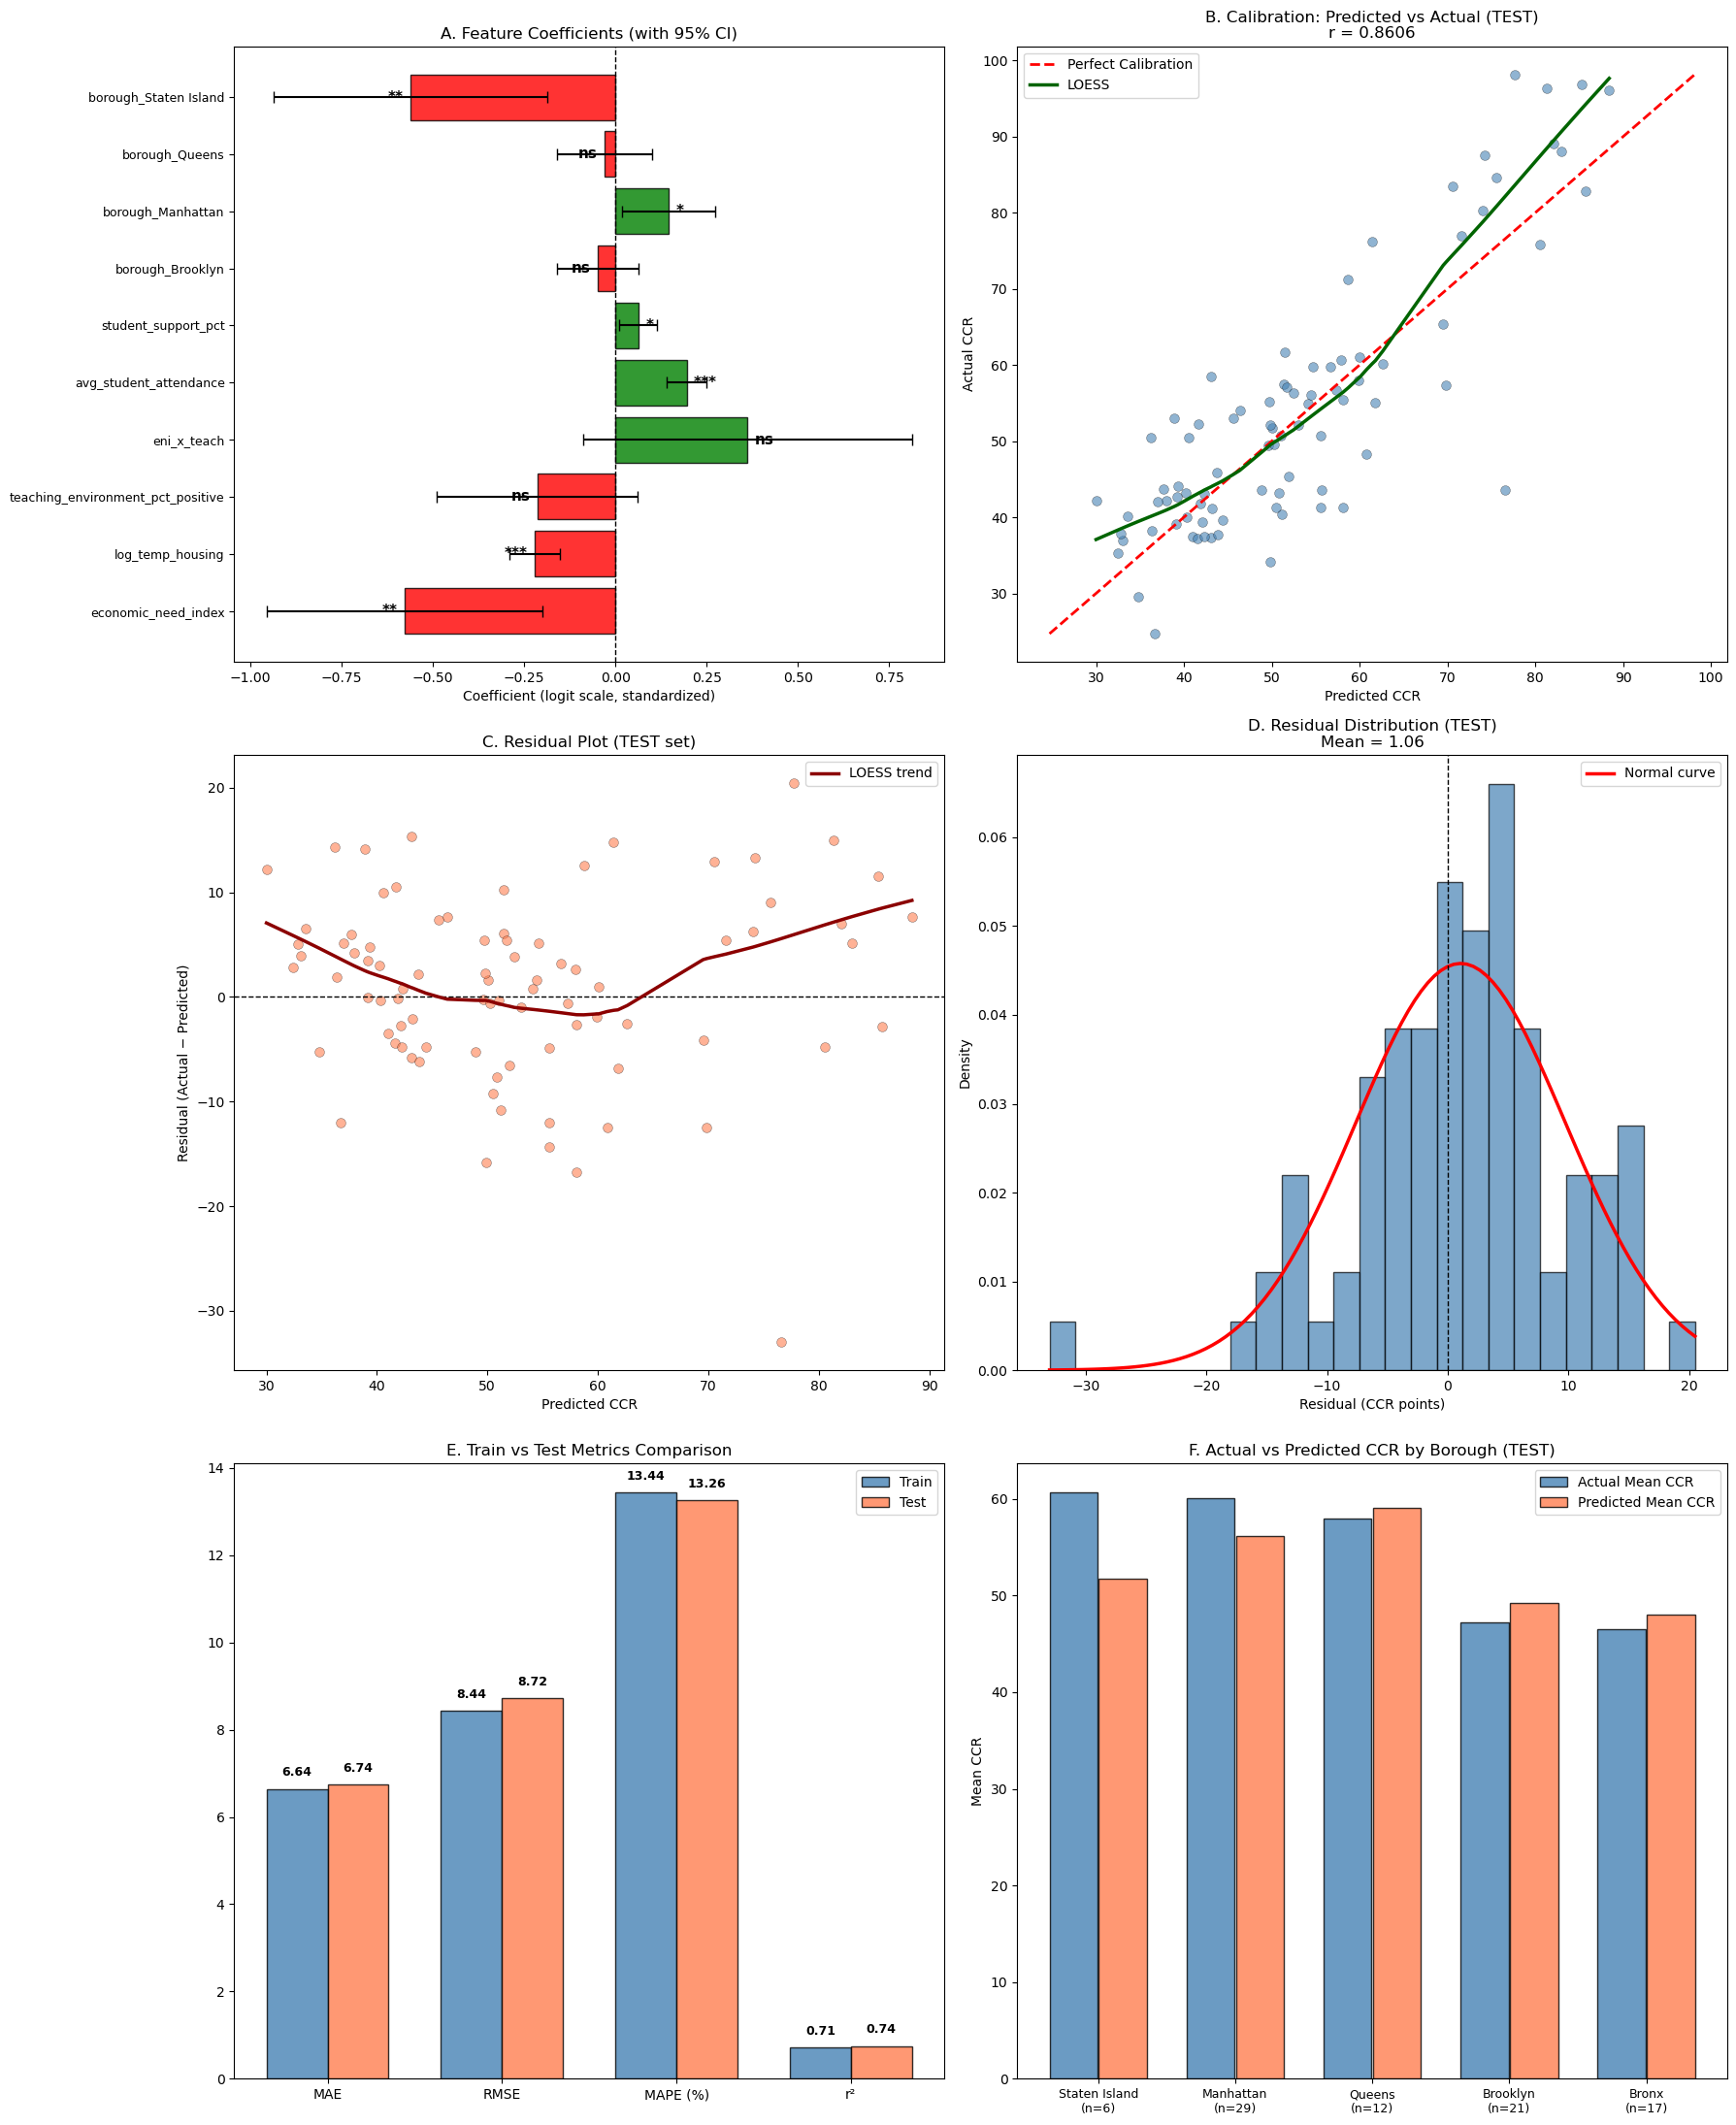

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(18, 22))

# Panel A: Coefficient Plot
plot_coefs = coef_df.drop('const', errors='ignore')
colors_coef = ['green' if c > 0 else 'red' for c in plot_coefs['Coefficient']]
y_pos = range(len(plot_coefs))
axes[0, 0].barh(y_pos, plot_coefs['Coefficient'],
                xerr=1.96 * plot_coefs['Std Error'],
                color=colors_coef, edgecolor='black', alpha=0.8, capsize=4)
axes[0, 0].set_yticks(y_pos)
axes[0, 0].set_yticklabels(plot_coefs.index, fontsize=9)
axes[0, 0].axvline(x=0, color='black', linewidth=1, linestyle='--')
axes[0, 0].set_xlabel('Coefficient (logit scale, standardized)')
axes[0, 0].set_title('A. Feature Coefficients (with 95% CI)')
for i, (idx, row) in enumerate(plot_coefs.iterrows()):
    axes[0, 0].text(row['Coefficient'] + 0.02 if row['Coefficient'] > 0 else row['Coefficient'] - 0.02,
                     i, row['Significant'], va='center', fontweight='bold', fontsize=11,
                     ha='left' if row['Coefficient'] > 0 else 'right')

# Panel B: Calibration Plot (TEST set)
axes[0, 1].scatter(y_pred_test_ccr, y_raw_test, alpha=0.6, c='steelblue',
                    edgecolors='black', linewidth=0.3, s=50)
cal_min = min(y_pred_test_ccr.min(), y_raw_test.min())
cal_max = max(y_pred_test_ccr.max(), y_raw_test.max())
axes[0, 1].plot([cal_min, cal_max], [cal_min, cal_max], 'r--', linewidth=2, label='Perfect Calibration')
smooth_cal = lowess(y_raw_test, y_pred_test_ccr, frac=0.5)
axes[0, 1].plot(smooth_cal[:, 0], smooth_cal[:, 1], color='darkgreen', linewidth=2.5, label='LOESS')
axes[0, 1].set_xlabel('Predicted CCR')
axes[0, 1].set_ylabel('Actual CCR')
axes[0, 1].set_title(f'B. Calibration: Predicted vs Actual (TEST)\nr = {test_metrics["Pearson r"]:.4f}')
axes[0, 1].legend()

# Panel C: Residuals vs Predicted (TEST)
axes[1, 0].scatter(y_pred_test_ccr, test_resid, alpha=0.6, c='coral',
                    edgecolors='black', linewidth=0.3, s=50)
axes[1, 0].axhline(y=0, color='black', linewidth=1, linestyle='--')
smooth_r = lowess(test_resid, y_pred_test_ccr, frac=0.5)
axes[1, 0].plot(smooth_r[:, 0], smooth_r[:, 1], color='darkred', linewidth=2.5, label='LOESS trend')
axes[1, 0].set_xlabel('Predicted CCR')
axes[1, 0].set_ylabel('Residual (Actual − Predicted)')
axes[1, 0].set_title('C. Residual Plot (TEST set)')
axes[1, 0].legend()

# Panel D: Residual Distribution (TEST)
axes[1, 1].hist(test_resid, bins=25, density=True, alpha=0.7, color='steelblue', edgecolor='black')
x_norm = np.linspace(test_resid.min(), test_resid.max(), 100)
axes[1, 1].plot(x_norm, norm.pdf(x_norm, test_resid.mean(), test_resid.std()),
                color='red', linewidth=2.5, label='Normal curve')
axes[1, 1].axvline(x=0, color='black', linewidth=1, linestyle='--')
axes[1, 1].set_xlabel('Residual (CCR points)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title(f'D. Residual Distribution (TEST)\nMean = {test_resid.mean():.2f}')
axes[1, 1].legend()

# Panel E: Train vs Test comparison
metrics_compare = pd.DataFrame([train_metrics, test_metrics]).set_index('Set')
bar_width = 0.35
x_pos = np.arange(4)
metric_cols = ['MAE', 'RMSE', 'MAPE (%)', 'r²']
train_vals = [metrics_compare.loc['Train', m] for m in metric_cols]
test_vals = [metrics_compare.loc['Test', m] for m in metric_cols]

axes[2, 0].bar(x_pos - bar_width/2, train_vals, bar_width, color='steelblue',
               edgecolor='black', alpha=0.8, label='Train')
axes[2, 0].bar(x_pos + bar_width/2, test_vals, bar_width, color='coral',
               edgecolor='black', alpha=0.8, label='Test')
axes[2, 0].set_xticks(x_pos)
axes[2, 0].set_xticklabels(metric_cols)
axes[2, 0].set_title('E. Train vs Test Metrics Comparison')
axes[2, 0].legend()
for i, (tr, te) in enumerate(zip(train_vals, test_vals)):
    axes[2, 0].text(i - bar_width/2, tr + 0.3, f'{tr:.2f}', ha='center', fontsize=9, fontweight='bold')
    axes[2, 0].text(i + bar_width/2, te + 0.3, f'{te:.2f}', ha='center', fontsize=9, fontweight='bold')

# Panel F: Actual vs Predicted by Borough (TEST)
test_idx = X_test.index
borough_test = model_df.loc[test_idx, 'borough'].values
borough_pred_df = pd.DataFrame({
    'borough': borough_test, 'actual': y_raw_test, 'predicted': y_pred_test_ccr
})
borough_summary = borough_pred_df.groupby('borough').agg(
    actual_mean=('actual', 'mean'),
    predicted_mean=('predicted', 'mean'),
    n=('actual', 'count')
).sort_values('actual_mean', ascending=False)

x_b = np.arange(len(borough_summary))
axes[2, 1].bar(x_b - 0.18, borough_summary['actual_mean'], 0.35, color='steelblue',
               edgecolor='black', alpha=0.8, label='Actual Mean CCR')
axes[2, 1].bar(x_b + 0.18, borough_summary['predicted_mean'], 0.35, color='coral',
               edgecolor='black', alpha=0.8, label='Predicted Mean CCR')
axes[2, 1].set_xticks(x_b)
axes[2, 1].set_xticklabels([f'{b}\n(n={int(n)})' for b, n in zip(borough_summary.index, borough_summary['n'])],
                            fontsize=9)
axes[2, 1].set_ylabel('Mean CCR')
axes[2, 1].set_title('F. Actual vs Predicted CCR by Borough (TEST)')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

## Step 7: Back-Transformed Coefficient Interpretation

Since features are **standardized** and the model uses a **logit link**, raw coefficients are on the log-odds scale. To make them interpretable:

- **Intercept**: Back-transform via inverse logit → predicted CCR when all features are at their average
- **Numerical features**: A 1-SD increase shifts CCR by the back-transformed difference (non-linear due to logit)
- **Borough dummies**: Compared to the reference borough (dropped category), the coefficient gives the CCR difference holding all else equal
- **Interaction term**: Tests whether teaching environment's effect on CCR depends on ENI level

In [10]:
for name in param_names:
    coef = beta_model_full.params[name]
    pval = beta_model_full.pvalues[name]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'NOT significant'

    if name == 'const':
        pred_at_mean = 1 / (1 + np.exp(-coef)) * 100
        print(f'INTERCEPT (β = {coef:.4f}, {sig}):')
        print(f'  → When all features are at their AVERAGE value, predicted CCR = {pred_at_mean:.1f}%\n')

    elif name == 'economic_need_index':
        eni_std = scaler.scale_[numerical_features.index('economic_need_index')]
        pred_base = 1 / (1 + np.exp(-beta_model_full.params['const'])) * 100
        pred_plus1sd = 1 / (1 + np.exp(-(beta_model_full.params['const'] + coef))) * 100
        print(f'ECONOMIC NEED INDEX (β = {coef:.4f}, {sig}):')
        print(f'  → A 1-SD increase in ENI ({eni_std:.3f} raw units):')
        print(f'    CCR shifts from ~{pred_base:.1f}% → ~{pred_plus1sd:.1f}% (≈ {pred_plus1sd - pred_base:+.1f} pts)')
        print(f'  → ENI is the STRONGEST negative predictor of CCR\n')

    elif name == 'log_temp_housing':
        pred_base = 1 / (1 + np.exp(-beta_model_full.params['const'])) * 100
        pred_plus1sd = 1 / (1 + np.exp(-(beta_model_full.params['const'] + coef))) * 100
        print(f'LOG TEMP HOUSING (β = {coef:.4f}, {sig}):')
        print(f'  → A 1-SD increase in log(temp housing) → CCR shifts by ~{pred_plus1sd - pred_base:+.1f} pts')
        print(f'  → Housing instability independently hurts CCR beyond ENI\n')

    elif name == 'teaching_environment_pct_positive':
        pred_base = 1 / (1 + np.exp(-beta_model_full.params['const'])) * 100
        pred_plus1sd = 1 / (1 + np.exp(-(beta_model_full.params['const'] + coef))) * 100
        print(f'TEACHING ENVIRONMENT (β = {coef:.4f}, {sig}):')
        print(f'  → A 1-SD improvement → CCR shifts by ~{pred_plus1sd - pred_base:+.1f} pts')
        if coef > 0:
            print(f'  → Better teaching environments are associated with HIGHER CCR\n')

    elif name == 'eni_x_teach':
        print(f'ENI × TEACHING INTERACTION (β = {coef:.4f}, {sig}):')
        if pval < 0.05 and coef > 0:
            print(f'  → POSITIVE interaction: teaching environment BUFFERS ENI damage')
            print(f'  → In high-ENI schools, a good teaching environment helps MORE\n')
        elif pval < 0.05 and coef < 0:
            print(f'  → NEGATIVE interaction: benefit of teaching env is WEAKER in high-ENI schools\n')
        else:
            print(f'  → Interaction is not statistically significant')
            print(f'  → Teaching environment effect is roughly CONSTANT across ENI levels\n')

    elif name == 'avg_student_attendance':
        attend_std = scaler.scale_[numerical_features.index('avg_student_attendance')]
        pred_base = 1 / (1 + np.exp(-beta_model_full.params['const'])) * 100
        pred_plus1sd = 1 / (1 + np.exp(-(beta_model_full.params['const'] + coef))) * 100
        print(f'AVG STUDENT ATTENDANCE (β = {coef:.4f}, {sig}):')
        print(f'  → A 1-SD increase ({attend_std:.3f} raw units) → CCR shifts by ~{pred_plus1sd - pred_base:+.1f} pts')
        if coef > 0:
            print(f'  → Higher attendance is associated with HIGHER CCR\n')
        else:
            print(f'  → Negative association after controlling for other factors\n')

    elif name == 'student_support_pct':
        support_std = scaler.scale_[numerical_features.index('student_support_pct')]
        pred_base = 1 / (1 + np.exp(-beta_model_full.params['const'])) * 100
        pred_plus1sd = 1 / (1 + np.exp(-(beta_model_full.params['const'] + coef))) * 100
        print(f'STUDENT SUPPORT (β = {coef:.4f}, {sig}):')
        print(f'  → A 1-SD increase ({support_std:.3f} raw units) → CCR shifts by ~{pred_plus1sd - pred_base:+.1f} pts')
        if coef > 0:
            print(f'  → Stronger student support programs are associated with HIGHER CCR')
            print(f'  → This is a MODIFIABLE factor — schools can invest in student support\n')
        else:
            print(f'  → Negative coefficient may indicate suppression or confounding')
            print(f'  → Schools with more support may serve higher-need populations\n')

    elif name.startswith('borough_'):
        borough_name = name.replace('borough_', '')
        pred_base = 1 / (1 + np.exp(-beta_model_full.params['const'])) * 100
        pred_borough = 1 / (1 + np.exp(-(beta_model_full.params['const'] + coef))) * 100
        direction = 'higher' if coef > 0 else 'lower'
        print(f'{borough_name.upper()} (β = {coef:.4f}, {sig}):')
        print(f'  → Compared to reference borough: ~{abs(pred_borough - pred_base):.1f} pts {direction} CCR, all else equal\n')

INTERCEPT (β = 0.1496, ***):
  → When all features are at their AVERAGE value, predicted CCR = 53.7%

ECONOMIC NEED INDEX (β = -0.5778, **):
  → A 1-SD increase in ENI (0.136 raw units):
    CCR shifts from ~53.7% → ~39.5% (≈ -14.3 pts)
  → ENI is the STRONGEST negative predictor of CCR

LOG TEMP HOUSING (β = -0.2207, ***):
  → A 1-SD increase in log(temp housing) → CCR shifts by ~-5.5 pts
  → Housing instability independently hurts CCR beyond ENI

TEACHING ENVIRONMENT (β = -0.2137, NOT significant):
  → A 1-SD improvement → CCR shifts by ~-5.3 pts
ENI × TEACHING INTERACTION (β = 0.3619, NOT significant):
  → Interaction is not statistically significant
  → Teaching environment effect is roughly CONSTANT across ENI levels

AVG STUDENT ATTENDANCE (β = 0.1950, ***):
  → A 1-SD increase (0.051 raw units) → CCR shifts by ~+4.8 pts
  → Higher attendance is associated with HIGHER CCR

STUDENT SUPPORT (β = 0.0626, *):
  → A 1-SD increase (0.057 raw units) → CCR shifts by ~+1.6 pts
  → Stronge

## Step 8: Overfitting Check & Summary

Assess model generalization by comparing train vs test metrics:
- **MAE gap < 2 pts** and **r² gap < 0.05** → model generalizes well ✅
- Larger gaps may indicate overfitting to training data

Also evaluate **per-borough performance** to check for systematic bias in specific geographies.

In [11]:
mae_gap = abs(train_metrics['MAE'] - test_metrics['MAE'])
r2_gap = abs(train_metrics['r²'] - test_metrics['r²'])

print('OVERFITTING CHECK')
print('=' * 50)
print(f'  MAE gap (train - test):  {train_metrics["MAE"] - test_metrics["MAE"]:+.2f}')
print(f'  r² gap  (train - test):  {train_metrics["r²"] - test_metrics["r²"]:+.4f}')
if mae_gap < 2 and r2_gap < 0.05:
    print(f'  → ✅ Model generalizes WELL (small train-test gap)')
elif mae_gap < 4:
    print(f'  → ⚠️ SLIGHT overfitting (moderate gap)')
else:
    print(f'  → ❌ Potential OVERFITTING (large gap between train and test)')

print(f'\nPERFORMANCE BY BOROUGH (TEST SET)')
print('=' * 50)
for borough_name, group in borough_pred_df.groupby('borough'):
    b_mae = np.mean(np.abs(group['actual'] - group['predicted']))
    b_bias = np.mean(group['actual'] - group['predicted'])
    print(f'  {borough_name:<15} N={len(group):>3}  MAE={b_mae:.1f}  Bias={b_bias:+.1f}')

OVERFITTING CHECK
  MAE gap (train - test):  -0.11
  r² gap  (train - test):  -0.0258
  → ✅ Model generalizes WELL (small train-test gap)

PERFORMANCE BY BOROUGH (TEST SET)
  Bronx           N= 17  MAE=5.3  Bias=-1.5
  Brooklyn        N= 21  MAE=7.9  Bias=-2.0
  Manhattan       N= 29  MAE=6.8  Bias=+4.0
  Queens          N= 12  MAE=5.6  Bias=-1.1
  Staten Island   N=  6  MAE=8.9  Bias=+8.9
